In [ ]:
# default_exp plots

# Plots

> This module defines functions for plotting the ridge reliability and confidence reliability diagrams. Both types of diagrams can be plotted with one figure per class (class-wise) or one aggregated figure for the classifier.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export

from ridgereliability import utils, metrics as rmetrics

import matplotlib.pyplot as plt
import matplotlib.axes
from matplotlib import gridspec, cm

import numpy as np
from scipy.stats import beta
from scipy import interpolate
from ridgereliability.beta import get_beta_parameters, beta_avg_pdf

import sklearn.datasets
import sklearn.model_selection
import sklearn.svm
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import sklearn.utils

In [ ]:
# exporti

def _decorate_ax(ax:matplotlib.axes.Axes):
    """Apply styling changes to a matplotlib axis.

    Arguments:
    ax -- matplotlib axis
    """

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.setp(ax.spines.values(), color=cm.tab20c(18))
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=cm.tab20c(18))
    
def _get_beta_pdf(dist):
    """Get pdf and beta parameters from `dist`.
    
    `dist` is either:
     - a tuple which contains a and b, in which case the exact pdf is sampled
     - a vector containing samples from a beta pdf (with unknown a and b), in which case MLE is used to estimate a and b
    
    Returns:
    tuple containing a, b, pdf and linspace x over which the pdf was sampled
    """
    
    if len(dist) == 2:
        # dist contains the parameters of the beta distribution
        a, b = dist

        # sample the beta
        x = np.linspace(0, 1, 500)
        pdf = beta.pdf(x, a, b)
    else:
        # dist contains samples of the beta pdf

        ## sample from the beta distribution using the pdf probabilities

        # make it impossible to sample 0 or 1
        # in theory this should never happen, but approximations introduce errors
        prob = dist.copy()
        prob[0] = 0.0
        prob[-1] = 0.0

        x = np.linspace(0, 1, len(dist))
        samples = np.random.choice(x, size=500, p=prob/prob.sum())

        ## fit a beta distribution to the samples
        a, b, loc, scale = beta.fit(samples, floc=0, fscale=1)

        pdf = dist
        
    return a, b, pdf, x

def _pre_plot_checks(y_probs, y_preds, y_true, ax, ci=None, required_axes=None):
    """Perform some pre-plotting checks on input data, create required axes if necessary and compute number of classes."""
    
    num_classes = len(sklearn.utils.multiclass.unique_labels(y_preds, y_true))
    
    if (required_axes == 1) and (ax is None):
            fig, ax = plt.subplots(subplot_kw={"aspect": 0.75}, dpi=100, tight_layout=True)
    else:
        required_axes = num_classes if required_axes is None else required_axes
        if ax is None:
            fig, ax = plt.subplots(1, required_axes, figsize=(3*required_axes, 3), subplot_kw={"aspect": 0.75}, constrained_layout=True, sharex=True, sharey=True, dpi=100)
        if (required_axes != 1) and (len(ax) != required_axes):
            raise ValueError(f"Wrong amount of axes provided: {required_axes} needed, but {len(ax)} provided.")
        
    sklearn.utils.check_consistent_length(y_probs, y_preds, y_true)
    
    if ci is not None:
        ci = ci if isinstance(ci, list) else [ci]
        for a in ci:
            if (a > 1) or (a < 0):
                raise ValueError(f"CI must be in [0, 1]")

    return num_classes, ax
    
    
class clipped_cm:
        def __init__(self, n, base_cm=cm.Greys, clip_range=(0.5, 1.0)):
            self.n = n
            self.space = np.linspace(*clip_range, n+1)
            self.cm = [base_cm(p) for p in self.space]

        def __call__(self, x):
            return self.cm[int(x*self.n)]

## Probabilistic classification: toy example

In [ ]:
np.random.seed(42)

In [ ]:
X, y = sklearn.datasets.make_classification(n_samples=5000, n_features=12, n_informative=3, n_classes=3)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
logreg = sklearn.svm.SVC(probability=True)

In [ ]:
logreg.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
y_probs = logreg.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_probs.argmax(axis=1))}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_probs.argmax(axis=1))}")

Accuracy: 0.808
Balanced accuracy: 0.8084048918146675


## Ridge reliability diagram

In [ ]:
# exporti

def river_diagram(distributions:np.array, confidence_levels:np.array, ax:matplotlib.axes.Axes, ci:list):
    
    ci = sorted(ci)[::-1]

    _decorate_ax(ax)
    ax.set_ylim(0, 1)

    intervals = np.empty((len(confidence_levels), len(ci), 2), dtype=float)
    means = np.empty((len(confidence_levels),), dtype=float)
    for i, (cl, dist) in enumerate(zip(confidence_levels, distributions)):
        if cl is np.nan:
            continue

        a, b, pdf, _ = _get_beta_pdf(dist)

        for j, l in enumerate(ci):
            intervals[i, j] = beta.interval(l, a, b)
        means[i] = a/(a+b)
        
    x = np.linspace(min(confidence_levels), max(confidence_levels), 1000)
    for i, l in enumerate(ci):
        f0 = interpolate.PchipInterpolator(confidence_levels, intervals[:, i, 0])
        f1 = interpolate.PchipInterpolator(confidence_levels, intervals[:, i, 1])
        
        ax.fill_between(x, f0(x), f1(x), zorder=i, color=cm.Greys(0.2+i*0.1), label=f"{int(l*100):2d}% CI")
        
    fm = interpolate.PchipInterpolator(confidence_levels, means)
    ax.plot(x, fm(x), color="black", zorder=4, label="Mean")
    ax.scatter(confidence_levels, means, s=20, color="black", zorder=4)
    ax.plot([0,1], [0,1], color=cm.Greys(0.8), linestyle="--", zorder=5, label="Perfect calibration")

In [ ]:
# export

def river_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, ax:matplotlib.axes.Axes=None, bins="fd", ci=[0.90, 0.95, 0.99]):
    """Plot the posterior balanced accuracy-based reliability diagram.
    
    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    ci -- Confidence interval level to plot. When style is river provide a list, otherwise a float.
    
    Returns:
    Axes containing the plot
    """
    
    num_classes, ax = _pre_plot_checks(y_probs, y_preds, y_true, ax, ci, required_axes=1)

    # bin the probabilities
    bin_indices, edges = utils.get_bin_indices(y_probs, bins, 0.0, 1.0, return_edges=True)
    unique_bin_indices = sorted(np.unique(bin_indices))

    confidence_levels = np.empty((len(unique_bin_indices),), dtype=np.float32) # store mean confidence

    if len(np.unique(y_preds)) > 1:
        # the beta distribution will be the average of the per-class distribution
        n_samples = 10000
        distributions = np.empty((len(unique_bin_indices), n_samples), dtype=np.float32) # store beta parameters
        x = np.linspace(0, 1, n_samples)
    else:
        # the beta distributions will be exact
        distributions = np.empty((len(unique_bin_indices), 2), dtype=np.int)

    # compute beta distribution per bin
    for i, bin_idx in enumerate(unique_bin_indices):
        
        # select instances in this bin
        selector = bin_indices == bin_idx

        # set the confidence level to the average confidence reported in the bin
        confidence_levels[i] = y_probs[selector].mean()

        if len(np.unique(y_preds)) > 1:
            # compute the average beta distribution
            conf = confusion_matrix(y_true[selector], y_preds[selector])#, labels=np.arange(0, num_classes))
            parameters = get_beta_parameters(conf)
            distributions[i] = np.clip(beta_avg_pdf(x, parameters, fft=True), 0, None)
        else:
            # compute the exact beta distribution
            correct = (y_true[selector] == y_preds[selector]).sum()
            incorrect = len(y_true[selector]) - correct
            distributions[i] = correct + 1, incorrect + 1

    # plot the actual diagram
    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Posterior balanced accuracy")
    ci = [0.90, 0.95, 0.99] if ci is None else ci
    river_diagram(distributions, confidence_levels, ax, ci=ci)
                
    return ax


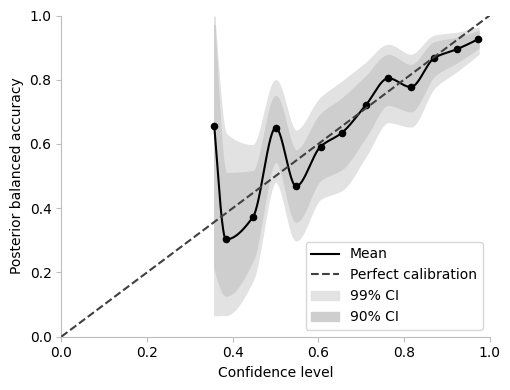

In [ ]:
ax = river_reliability_diagram(y_probs.max(axis=1), y_probs.argmax(axis=1), y_test, bins="fd", ci=[0.90, 0.99])
ax.legend(loc="lower right")
plt.savefig("example.pdf")

In [ ]:
# export

def class_wise_river_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, axes:matplotlib.axes.Axes=None, bins="fd", metric=None, show_k_least_calibrated:int=None, ci=[0.90, 0.95, 0.99]):
    """Plot the class-wise posterior balanced accuracy-based reliability diagram.
    
    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    axes -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    ci -- Confidence interval level to plot. When style is river provide a list, otherwise a float.
    
    Returns:
    Axes containing the plot
    """
    
    
    num_classes, axes = _pre_plot_checks(y_probs, y_preds, y_true, axes, ci, show_k_least_calibrated)

    if metric is None:
        a = np.arange(num_classes)
    else:
        metric_values = []
        for c in np.arange(num_classes):
            selector = y_preds == c
            metric_values.append(metric(y_probs[selector, c], y_preds[selector], y_true[selector]))
            
        a = np.argsort(metric_values)[::-1][:show_k_least_calibrated]

    for ax, c in zip(axes, a):
        selector = y_preds == c

        if metric is None:
            ax.set_title(f"Class {c}")
        else:
            ax.set_title(f"Class {c} ({metric_values[c]:.3f})")

        river_reliability_diagram(y_probs[selector, c], y_preds[selector], y_true[selector], ax, bins, ci=ci)
        
    return axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e831e2fa0>,
      dtype=object)

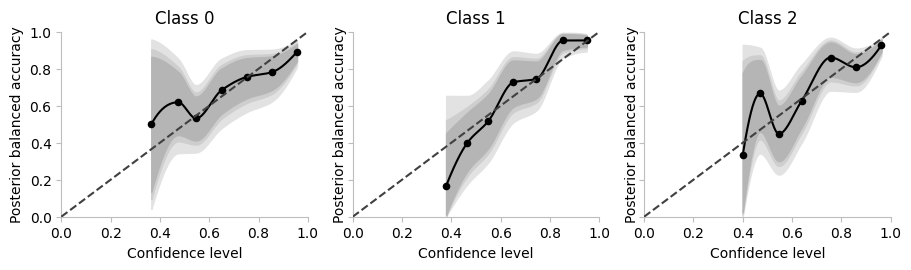

In [ ]:
class_wise_river_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, bins=10)

Provide an error metric to show the plots ordered according decreasing error.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e68f89340>,
      dtype=object)

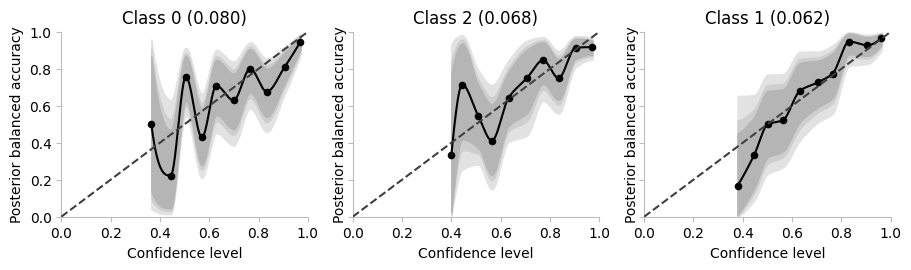

In [ ]:
class_wise_river_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, bins=15, metric=rmetrics.peace)

## Confidence reliability diagram

In [ ]:
# exporti

def bar_diagram(edges:np.array, bin_accuracies:np.array, bin_confidences:np.array, ax:matplotlib.axes.Axes, bin_sem:np.array=None):
    """Plot a bar plot confidence reliability diagram.

    Arguments:
    edges -- Edges of the probability bins
    bin_accuracies -- Accuracy per bin
    bin_confidences -- Average confidence of predictions in bin
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    """

    _decorate_ax(ax)
    cmap = clipped_cm(len(bin_accuracies), clip_range=(0.2, 0.7))

    ax.plot([0,1], [0,1], linestyle="--", color=cmap(1), alpha=0.9, linewidth=1)

    for i, (xi, yi, bi) in enumerate(zip(edges, bin_accuracies, bin_confidences)):
        if np.isnan(bi):
            continue
        if yi < 0:
            continue
        if bin_sem is not None:
            sem = bin_sem[i]
        else:
            sem = 0.

        # plot bin value
        ax.bar(xi, yi, width=edges[1], align="edge", color=cmap(1-bi), edgecolor="grey", yerr=sem, linewidth=1, zorder=0)
        
        # plot gap to ideal value
        ax.bar(
            xi+edges[1]/2, np.abs(bi-yi), bottom=min(bi, yi), width=edges[1], 
            align="center", color=cmap(0), edgecolor="grey", linewidth=1, zorder=1
        )

In [ ]:
# export

def confidence_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, ax:matplotlib.axes.Axes=None, bins="fd", balanced:bool=True):
    """Plot a confidence reliability diagram.

    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    balanced -- Flag for using balanced accuracy score
    """
    
    num_classes, ax = _pre_plot_checks(y_probs, y_preds, y_true, ax, required_axes=1)

    bin_indices, edges = utils.get_bin_indices(y_probs, bins, 0.0, 1.0, return_edges=True)
    unique_bin_indices = sorted(np.unique(bin_indices))

    mean_confidences = np.full((len(edges)-1,), dtype=np.float32, fill_value=np.nan)
    bin_metric = np.full((len(edges)-1,), dtype=np.float32, fill_value=np.nan)

    metric = balanced_accuracy_score if balanced else accuracy_score

    ax.set_xlabel("Confidence level")
    ax.set_ylabel("Balanced accuracy" if balanced else "Accuracy")

    for bin_idx in unique_bin_indices:
        selector = bin_indices == bin_idx

        mean_confidences[bin_idx-1] = np.mean(y_probs[selector])
        bin_metric[bin_idx-1] = metric(y_true[selector], y_preds[selector])

        bar_diagram(edges, bin_metric, mean_confidences, ax)

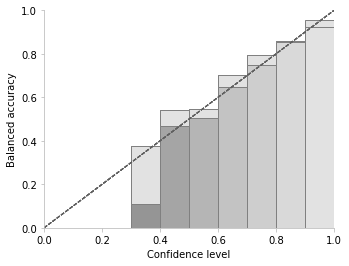

In [ ]:
fig, ax = plt.subplots(subplot_kw={"aspect": 0.75})
confidence_reliability_diagram(y_probs.max(axis=1), y_probs.argmax(axis=1), y_test, ax, bins=10)

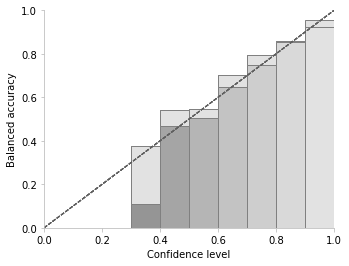

In [ ]:
fig, ax = plt.subplots(subplot_kw={"aspect": 0.75})
confidence_reliability_diagram(y_probs.max(axis=1), y_probs.argmax(axis=1), y_test, ax, bins=10, balanced=True)

In [ ]:
# export

def class_wise_confidence_reliability_diagram(y_probs:np.array, y_preds:np.array, y_true:np.array, axes:matplotlib.axes.Axes, bins="fd"):
    """Plot a class-wise confidence reliability diagram.

    Arguments:
    y_probs -- Array containing prediction confidences
    y_preds -- Array containing predicted labels (shape (N,))
    y_true -- Array containing true labels (shape (N,))
    ax -- Axes on which the diagram will be plotted (will be decorated by `_decorate_ax`)
    bins -- Description of amount of bins in which to divide prediction confidences (see `numpy.histogram_bin_edges` for options)
    balanced -- Flag for using balanced accuracy score
    """

    classes = np.unique(y_true)

    for ax, c in zip(axes, range(len(classes))):
        ax.set_title(f"Class {c}")
        
        selector = y_preds == c

        confidence_reliability_diagram(y_probs[selector, c], y_preds[selector], y_true[selector], ax, bins, balanced=False)

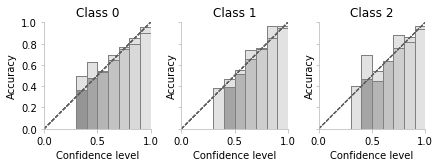

In [ ]:
fig, ax = plt.subplots(1, 3, subplot_kw={"aspect": 1}, constrained_layout=True, sharex=True, sharey=True)
class_wise_confidence_reliability_diagram(y_probs, y_probs.argmax(axis=1), y_test, ax, bins=10)